In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import optuna


import warnings
warnings.filterwarnings('ignore')

In [125]:
data = pd.read_csv('datasets/ufc-master.csv')

Удаляем строки, где бой завершился дисквалификацией или `No contest`

In [126]:
mask = ~data['Finish'].isin(['DQ', 'Overturned'])
data = data[mask] # удалили 20 строк

In [127]:
data['Finish'].value_counts()

Finish
U-DEC     2404
KO/TKO    2009
SUB       1157
S-DEC      654
M-DEC       46
Name: count, dtype: int64

Удаляем ненужные признаки

In [128]:
valuable_features = ['RedFighter',
                     'BlueFighter',                  
                     'WeightClass',
                     'Gender',
                     'Winner',
                     'Finish',
                     'Date',
                     'NumberOfRounds',
                     'RedAge',
                     'RedHeightCms',
                     'RedReachCms',
                     'RedWeightLbs',
                     'RedStance',
                     'RedWins',
                     'RedWinsByDecisionMajority',
                     'RedWinsByDecisionSplit',
                     'RedWinsByDecisionUnanimous',
                     'RedWinsByKO',
                     'RedWinsByTKODoctorStoppage',
                     'RedWinsBySubmission',
                     'RedCurrentWinStreak',
                     'RedLosses',
                     'RedCurrentLoseStreak',
                     'RedAvgSigStrLanded',
                     'RedAvgSigStrPct',                     
                     'RedAvgSubAtt',
                     'RedAvgTDLanded',
                     'RedAvgTDPct',
                     'RedTotalRoundsFought',
                     'RedLongestWinStreak',
                     'BlueAge',
                     'BlueHeightCms',
                     'BlueReachCms',
                     'BlueWeightLbs',
                     'BlueStance',
                     'BlueWins',
                     'BlueWinsByDecisionMajority',
                     'BlueWinsByDecisionSplit',
                     'BlueWinsByDecisionUnanimous',
                     'BlueWinsByKO',
                     'BlueWinsByTKODoctorStoppage',
                     'BlueWinsBySubmission',
                     'BlueCurrentWinStreak',
                     'BlueLosses', 
                     'BlueCurrentLoseStreak',                    
                     'BlueAvgSigStrLanded',                 # Среднее количество значимых ударов, выбрасываемых в минуту синим бойцом
                     'BlueAvgSigStrPct',                    # Соотношение значимых попаданий к общему количеству значимых ударов для синего бойца   
                     'BlueAvgSubAtt',                       # Среднее количесвто попыток болевого приема за 15 минут для синего бойца
                     'BlueAvgTDLanded',                     # Среднее количесвто тейкдаунов за 15 минут для синего бойца
                     'BlueAvgTDPct',                        # Соотношение успешных тейкдаунов к общему количеству попыток для синего бойца
                     'BlueTotalRoundsFought',
                     'BlueLongestWinStreak',
                     'RedOdds',
                     'BlueOdds',
                     'RMatchWCRank',
                     'BMatchWCRank'
                    ]

data = data[valuable_features]

Объединяем признаки `Winner` и `Finish` в один признак `Result`

In [129]:
def def_target(row):
    if row['Winner'] == 'Red':
        if row['Finish'] == 'KO/TKO':
            return 'Red-KO/TKO'
        elif row['Finish'] == 'SUB':
            return 'Red-Submission'
        else:
            return 'Red-Decision'
    if row['Winner'] == 'Blue':
        if row['Finish'] == 'KO/TKO':
            return 'Blue-KO/TKO'
        elif row['Finish'] == 'SUB':
            return 'Blue-Submission'
        else:
            return 'Blue-Decision'
        
data['Result'] = data.apply(def_target, axis=1)

Объединим несколько признаков между собой для того, чтобы уменьшить количество признаков

In [130]:
data['RedWinsByDecision'] = data['RedWinsByDecisionMajority'] + data['RedWinsByDecisionSplit'] + data['RedWinsByDecisionUnanimous']
data['RedWinsByKO/TKO'] = data['RedWinsByKO'] + data['RedWinsByTKODoctorStoppage']

data['BlueWinsByDecision'] = data['BlueWinsByDecisionMajority'] + data['BlueWinsByDecisionSplit'] + data['BlueWinsByDecisionUnanimous']
data['BlueWinsByKO/TKO'] = data['BlueWinsByKO'] + data['BlueWinsByTKODoctorStoppage']

# Удалим лишние признаки
columns_to_drop = ['RedWinsByDecisionMajority',
                   'RedWinsByDecisionSplit',
                   'RedWinsByDecisionUnanimous',
                   'RedWinsByKO',
                   'RedWinsByTKODoctorStoppage',
                   'BlueWinsByDecisionMajority',
                   'BlueWinsByDecisionSplit',
                   'BlueWinsByDecisionUnanimous',
                   'BlueWinsByKO',
                   'BlueWinsByTKODoctorStoppage',
                   'Winner',
                   'Finish'
                   #'RedWeightLbs',
                   #'BlueWeightLbs'                          
                    ]

data = data.drop(columns=columns_to_drop, axis=1)

Бинарные и ориднильные признаки можно преобразовать в числовой вид 

In [131]:
binary_features = ['Gender', 'NumberOfRounds', 'RedStance', 'BlueStance']
data['Gender'] = data['Gender'].map({'FEMALE': 1, 'MALE': 0})
data['NumberOfRounds'] = data['NumberOfRounds'].map({3: 0, 5: 1})
data['RedStance'] = data['RedStance'].map({'Southpaw': 1, 'Orthodox': 0})
data['BlueStance'] = data['BlueStance'].map({'Southpaw': 1, 'Orthodox': 0})

ordinal_features = ['WeightClass', 'Result']
data['WeightClass'] = data['WeightClass'].map({"Women's Strawweight": 0,
                                               'Flyweight': 0,
                                               "Women's Flyweight": 0,
                                               'Bantamweight': 1,
                                               "Women's Bantamweight": 1,
                                               'Featherweight': 2,
                                               "Women's Featherweight": 2,
                                               'Catch Weight': 2,
                                               'Lightweight': 3,
                                               'Welterweight': 4,
                                               'Middleweight': 5,
                                               'Light Heavyweight': 6,
                                               'Heavyweight': 7})

data['Result'] = data['Result'].map({'Red-KO/TKO': 0,
                                     'Red-Submission': 1,
                                     'Red-Decision': 2,
                                     'Blue-KO/TKO': 3,
                                     'Blue-Submission' : 4,
                                     'Blue-Decision': 5                                     
                                    })

Бинаризуем `Result`

In [132]:
data['Result'] = data['Result'].isin([3, 4, 5]).astype(int)

Преобразуем признак рейтинга бойцов

In [133]:
def ranking_calc(row):
    for col in ['RMatchWCRank', 'BMatchWCRank']:
        if pd.isna(row[col]):
            row[col] = 0
        else:
            row[col] = 16 - row[col]
    return row

data = data.apply(ranking_calc, axis=1)

In [134]:
data

,RedFighter,BlueFighter,WeightClass,Gender,Date,NumberOfRounds,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,...,BlueLongestWinStreak,RedOdds,BlueOdds,RMatchWCRank,BMatchWCRank,Result,RedWinsByDecision,RedWinsByKO/TKO,BlueWinsByDecision,BlueWinsByKO/TKO
0,Alexandre Pantoja,Kai Asakura,0,0,2024-12-07,1.0,34,165.10,170.18,125,...,0,-250.0,215.0,16.0,0.0,0,6,2,0,0
1,Shavkat Rakhmonov,Ian Machado Garry,4,0,2024-12-07,0.0,30,185.42,195.58,170,...,8,-210.0,295.0,13.0,9.0,0,0,1,5,3
2,Ciryl Gane,Alexander Volkov,7,0,2024-12-07,0.0,34,193.04,205.74,245,...,4,-380.0,300.0,14.0,13.0,0,3,4,5,6
3,Bryce Mitchell,Kron Gracie,2,0,2024-12-07,0.0,30,177.80,177.80,145,...,1,-950.0,625.0,3.0,0.0,0,6,0,0,0
4,Nate Landwehr,Dooho Choi,2,0,2024-12-07,0.0,36,175.26,182.88,145,...,3,-130.0,110.0,0.0,0.0,1,2,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6523,Duane Ludwig,Darren Elkins,3,0,2010-03-21,0.0,31,177.80,177.80,170,...,0,-155.0,135.0,0.0,0.0,1,1,1,0,0
6524,John Howard,Daniel Roberts,4,0,2010-03-21,0.0,27,170.18,180.34,170,...,0,-210.0,175.0,0.0,0.0,0,2,1,0,0
6525,Brendan Schaub,Chase Gormley,7,0,2010-03-21,0.0,27,193.04,198.12,245,...,0,-260.0,220.0,0.0,0.0,0,0,0,0,0
6526,Mike Pierce,Julio Paulino,4,0,2010-03-21,0.0,29,172.72,177.80,170,...,0,-420.0,335.0,0.0,0.0,0,1,0,0,0


Создадим новый признак - время, прошедшее с момента последнего боя

In [135]:
# Преобразуем столбец 'Дата' в формат datetime
data['Date'] = pd.to_datetime(data['Date'])

# Создаем новый столбец для хранения времени с последнего боя
data['RedTimeSinceLastFight'] = None
data['BlueTimeSinceLastFight'] = None

# Итерируем по каждой строке датафрейма
for index, row in data.iterrows():
    # Для красного бойца
    mask = (data['RedFighter'] == row['RedFighter']) | (data['BlueFighter'] == row['RedFighter'])
    mask = mask & (data['Date'] < row['Date'])
    last_fight = data[mask]['Date'].max()
    if not pd.isnull(last_fight):
        data.loc[index, 'RedTimeSinceLastFight'] = row['Date'] - last_fight
    
    # Для синего бойца
    mask = (data['RedFighter'] == row['BlueFighter']) | (data['BlueFighter'] == row['BlueFighter'])
    mask = mask & (data['Date'] < row['Date'])
    last_fight = data[mask]['Date'].max()
    if not pd.isnull(last_fight):
        data.loc[index, 'BlueTimeSinceLastFight'] = row['Date'] - last_fight

data['RedTimeSinceLastFight'] = data['RedTimeSinceLastFight'].apply(lambda x: x.days if not pd.isnull(x) else 0).astype(int)
data['BlueTimeSinceLastFight'] = data['BlueTimeSinceLastFight'].apply(lambda x: x.days if not pd.isnull(x) else 0).astype(int)

data = data.drop('Date', axis=1)

Проверяем наличие пропусков

In [136]:
def check_columns_with_nans(df):
    flag = 0
    for col in df.columns:
        isna_sum = 0
        if df[col].isna().any():
            flag = 1 
            isna_sum = df[col].isna().sum()
            print(f'Количество пропусков в столбце {col}: {isna_sum}')
    if not flag:
        print('Пропусков в данных не обнаружено')

check_columns_with_nans(data)

Количество пропусков в столбце NumberOfRounds: 21
Количество пропусков в столбце RedStance: 374
Количество пропусков в столбце RedAvgSigStrLanded: 453
Количество пропусков в столбце RedAvgSigStrPct: 355
Количество пропусков в столбце RedAvgSubAtt: 355
Количество пропусков в столбце RedAvgTDLanded: 355
Количество пропусков в столбце RedAvgTDPct: 365
Количество пропусков в столбце BlueStance: 409
Количество пропусков в столбце BlueAvgSigStrLanded: 926
Количество пропусков в столбце BlueAvgSigStrPct: 761
Количество пропусков в столбце BlueAvgSubAtt: 828
Количество пропусков в столбце BlueAvgTDLanded: 829
Количество пропусков в столбце BlueAvgTDPct: 838
Количество пропусков в столбце RedOdds: 225
Количество пропусков в столбце BlueOdds: 224


Заполняем очевидные пропуски (там, где не нужно поднимать статистику, чтобы их заполнить)

In [137]:
data['NumberOfRounds'] = data['NumberOfRounds'].fillna(0)
data['RedStance'] = data['RedStance'].fillna(1)
data['BlueStance'] = data['BlueStance'].fillna(1)

Исправляем ошибки в статистических данных

In [138]:
stats_columns = ['RedAvgSigStrLanded',
                'BlueAvgSigStrLanded',
                'RedAvgSigStrPct',
                'BlueAvgSigStrPct',
                'RedAvgSubAtt',
                'BlueAvgSubAtt',
                'RedAvgTDLanded',
                'BlueAvgTDLanded',
                'RedAvgTDPct',
                'BlueAvgTDPct'
                ]   

def stats_columns_hist(df, columns):
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 19))
    for i in range(len(columns)):
        axs[int(i // 2), i % 2].hist(df[columns[i]], bins=30)
        axs[int(i // 2), i % 2].set_title(columns[i])
        axs[int(i // 2), i % 2].grid()

# stats_columns_hist(data, stats_columns)

In [ ]:
stats_columns_hist(data, stats_columns)

In [17]:
# data[(data['RedAvgSigStrLanded'] < 20)][['BlueFighter'] + red_cols]

### Заполняем пропуски в статистических признаках

In [118]:
check_columns_with_nans(data)

Количество пропусков в столбце Finish: 238
Количество пропусков в столбце RedAvgSigStrLanded: 453
Количество пропусков в столбце RedAvgSigStrPct: 355
Количество пропусков в столбце RedAvgSubAtt: 355
Количество пропусков в столбце RedAvgTDLanded: 355
Количество пропусков в столбце RedAvgTDPct: 365
Количество пропусков в столбце BlueAvgSigStrLanded: 926
Количество пропусков в столбце BlueAvgSigStrPct: 761
Количество пропусков в столбце BlueAvgSubAtt: 828
Количество пропусков в столбце BlueAvgTDLanded: 829
Количество пропусков в столбце BlueAvgTDPct: 838
Количество пропусков в столбце RedOdds: 225
Количество пропусков в столбце BlueOdds: 224


In [139]:
# Выберем дебютантов среди RedFighter
red_stats_cols = [col for col in stats_columns if col.find('Red') > -1]
blue_stats_cols = [col for col in stats_columns if col.find('Blue') > -1]

# Поскольку у дебютантов еще нет статистики (или, во всяком случае, не должно быть), заменяем все NaN нулями
data.loc[data['RedTotalRoundsFought'] == 0, red_stats_cols] = 0
data.loc[data['BlueTotalRoundsFought'] == 0, blue_stats_cols] = 0

In [140]:
red_cols = [col for col in data.columns if col.find('Red') > -1]
blue_cols = [col for col in data.columns if col.find('Blue') > -1]

# Проверим, сколько осталось бойцов-недебютантов с пропусками в статистике по ударам 
print(len(data[data['RedAvgSigStrLanded'].isna()][red_cols]))
print(len(data[data['BlueAvgSigStrLanded'].isna()][blue_cols]))

86
90


### Исправление данных по статистикам бойцов

In [141]:
# Cоберем реальную статистику по значимым ударам для каждого бойца
fighters_strikes = {}

# Проходим по датафрейму и собираем информацию по бойцам в красном углу
for index, row in data.iterrows():
    fighter = row['RedFighter']
    strikes = row['RedAvgSigStrLanded']

    # Для каждого бойца составляем список со всеми адекватными значениями количества ударов
    if 0 < strikes < 15 and pd.notna(strikes):   
        if fighter in fighters_strikes:
            fighters_strikes [fighter].append(strikes)
        else:
            fighters_strikes [fighter] = [strikes]

# Проходим по датафрейму и собираем информацию по бойцам в синем углу
for index, row in data.iterrows():
    fighter = row['BlueFighter']
    strikes = row['BlueAvgSigStrLanded']

    if 0 < strikes < 15 and pd.notna(strikes): 
        if fighter in fighters_strikes:
            fighters_strikes [fighter].append(strikes)
        else:
            fighters_strikes [fighter] = [strikes]

# Усредняем показатель по количеству ударов для каждого бойца
for k, v in fighters_strikes.items():
    fighters_strikes[k] = np.round(np.mean(np.array(v)), 2)

In [142]:
# Пройдемся среди недебютантов, поскольку тех мы уже обработали
for index, row in data.loc[data['RedTotalRoundsFought'] > 0, :].iterrows():
    # Для всех аномальных значений заменяем их на усредненное значение конкретно для этого бойца, взятое из словаря
    if pd.isna(row['RedAvgSigStrLanded']) or row['RedAvgSigStrLanded'] >= 15:
        if row['RedFighter'] in fighters_strikes:
            data.loc[index, 'RedAvgSigStrLanded'] = fighters_strikes[row['RedFighter']]

for index, row in data.loc[data['BlueTotalRoundsFought'] > 0, :].iterrows():        
    if pd.isna(row['BlueAvgSigStrLanded']) or row['BlueAvgSigStrLanded'] >= 15:
        # Для всех аномальных значений заменяем их на усредненное значение конкретно для этого бойца, взятое из словаря
        if row['BlueFighter'] in fighters_strikes:
            data.loc[index, 'BlueAvgSigStrLanded'] = fighters_strikes[row['BlueFighter']]

In [143]:
# Удаляем все остальные пропуски
check_columns_with_nans(data)
data = data.dropna()

Количество пропусков в столбце RedAvgSigStrLanded: 8
Количество пропусков в столбце RedAvgTDPct: 7
Количество пропусков в столбце BlueAvgSigStrLanded: 7
Количество пропусков в столбце BlueAvgTDLanded: 1
Количество пропусков в столбце BlueAvgTDPct: 9
Количество пропусков в столбце RedOdds: 225
Количество пропусков в столбце BlueOdds: 224


In [144]:
data[data['BlueFighter'] == 'Petr Yan']['BlueAvgSigStrLanded']
# data[data['RedFighter'] == 'Marlon Moraes']['RedAvgSigStrLanded']

1377    5.14
2742    5.21
2904    5.21
2968    5.21
3225    0.00
Name: BlueAvgSigStrLanded, dtype: float64

Проверим, по какому количеству бойцов исправить статистику по ударам не удалось из-за полного отсутствия адекватных данных по этим бойцам

In [145]:
print(data.loc[(data['RedTotalRoundsFought'] > 0) &  (data['RedAvgSigStrLanded'] == 0), red_cols]['RedFighter'].count())
print(data.loc[(data['BlueTotalRoundsFought'] > 0) &  (data['BlueAvgSigStrLanded'] == 0), blue_cols]['BlueFighter'].count())

12
16


Удалим бои с бойцами-недебютантами с нулевым количеством ударов

In [146]:
red_mask = (data['RedTotalRoundsFought'] > 0) & (data['RedAvgSigStrLanded'] == 0)
blue_mask = (data['BlueTotalRoundsFought'] > 0) & (data['BlueAvgSigStrLanded'] == 0)
data = data.loc[~red_mask]
data = data.loc[~blue_mask]

In [27]:
# # Добавим порядковый номер боя, чтобы не сбиться
# data['FightNumber'] = np.arange(len(data))

# # Определяем аномалии по заданной эвристике
# red_anomaly_mask = data['RedAvgSigStrLanded'] >= 15
# blue_anomaly_mask = data['BlueAvgSigStrLanded'] >= 15

# # Функция для замены аномальных цен на ближайшую реальную
# def replace_anomalies(group, column):
#     # Удаляем аномалии
#     clean_group = group[group[column] < 15]
    
#     # Если группа не пуста, заменяем аномалии на ближайшую реальную цену
#     if not clean_group.empty:
#         nearest_value = clean_group[column].iloc[-1]  # Берем последнюю реальную цену
        
#         # Заменяем аномалии на ближайшую реальную цену
#         group.loc[group[column] >= 15, column] = nearest_value
#         group.loc[group[column].isna(), column] = nearest_value
        
#     return group

# # Заменяем аномалии для каждого бойца
# temp = data.groupby('RedFighter').apply(replace_anomalies, column='RedAvgSigStrLanded')
# temp = temp.drop('RedFighter', axis=1).reset_index()
# temp = temp.sort_values(by='level_1')
# temp = temp.groupby('BlueFighter').apply(replace_anomalies, column='BlueAvgSigStrLanded')
# temp = temp.drop(['BlueFighter', 'level_1'], axis=1).reset_index()
# data = temp.drop('level_1', axis=1).sort_values(by='FightNumber')
# data.set_index('FightNumber', inplace=True)
# data

Проверим, сколько строчек до сих пор содержат аномальные значения по статистике ударов

In [147]:
# data_final = data[(data['RedAvgSigStrLanded'] < 10) & (data['BlueAvgSigStrLanded'] < 10)]
data[(data['RedAvgSigStrLanded'] > 15) | (data['BlueAvgSigStrLanded'] > 15)][['RedFighter', 
                                                                               'BlueFighter',
                                                                               'RedAvgSigStrLanded',
                                                                               'BlueAvgSigStrLanded',
                                                                               'RedTotalRoundsFought',
                                                                               'BlueTotalRoundsFought']][:5]

,RedFighter,BlueFighter,RedAvgSigStrLanded,BlueAvgSigStrLanded,RedTotalRoundsFought,BlueTotalRoundsFought
2744,Tatiana Suarez,Nina Ansaroff,4.2700,75.1667,8,18
2753,Jimi Manuwa,Aleksandar Rakic,26.0909,4.4200,21,7
2756,Daniel Teymur,Sung Bin Jo,41.0000,0.0000,8,0
2758,Tonya Evinger,Lina Lansberg,20.5000,4.9700,4,13
2759,Stevie Ray,Leonardo Santos,40.2222,2.6700,22,14


Видно, что начиная с 2744 строки в датасете начинаются абсурдные данные

In [148]:
# Удалим эти аномальные строки
data_final = data[(data['RedAvgSigStrLanded'] < 15) & (data['BlueAvgSigStrLanded'] < 15)]

In [30]:
# # Функция поиска выбросов и замены их на медиану
# def replace_outliers(series):
#     Q1 = series.quantile(0.25)
#     Q3 = series.quantile(0.75)
#     IQR = Q3 - Q1
    
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
    
#     median = series.median()
    
#     series.loc[(series > upper_bound)] = median
#     print(f'q25: {Q1}, q75: {Q3}, IQR: {IQR}, upper bound: {upper_bound}, median: {median}')
#     return series

# # Для каждой весовой категории ищем свою медиану и заменяем выбросы на нее
# for col in ['RedAvgSigStrLanded', 'BlueAvgSigStrLanded']:
#     print(data.loc[:, col].median())
#     data.loc[:, col] = replace_outliers(data.loc[:, col])

Финальная проверка на пропуски и наличие аномалий

In [149]:
check_columns_with_nans(data_final)

Пропусков в данных не обнаружено


In [ ]:
stats_columns_hist(data_final, stats_columns)

### Меняем местами бойцов в датасете

In [150]:
data_final_reversed_fighters = data_final.copy()

for r_col, b_col in list(zip(red_cols, blue_cols)):
    data_final_reversed_fighters[b_col] = data_final[r_col]
    data_final_reversed_fighters[r_col] = data_final[b_col]



data_final_reversed_fighters['Result'] = ~data_final['Result'].astype(bool)
data_final_reversed_fighters['Result'] = data_final_reversed_fighters['Result'].astype(int)
data_final_reversed_fighters

,RedFighter,BlueFighter,WeightClass,Gender,NumberOfRounds,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,RedStance,...,BlueOdds,RMatchWCRank,BMatchWCRank,Result,RedWinsByDecision,RedWinsByKO/TKO,BlueWinsByDecision,BlueWinsByKO/TKO,RedTimeSinceLastFight,BlueTimeSinceLastFight
0,Kai Asakura,Alexandre Pantoja,0,0,1.0,31,172.72,175.26,125,0.0,...,-250.0,16.0,0.0,1,0,0,6,2,0,217
1,Ian Machado Garry,Shavkat Rakhmonov,4,0,0.0,27,190.50,187.96,170,0.0,...,-210.0,13.0,9.0,1,5,3,0,1,161,357
2,Alexander Volkov,Ciryl Gane,7,0,0.0,36,200.66,203.20,250,0.0,...,-380.0,14.0,13.0,1,5,6,3,4,168,462
3,Kron Gracie,Bryce Mitchell,2,0,0.0,36,175.26,177.80,145,1.0,...,-950.0,3.0,0.0,1,0,0,6,0,581,357
4,Dooho Choi,Nate Landwehr,2,0,0.0,33,177.80,177.80,145,0.0,...,-130.0,0.0,0.0,0,0,4,2,1,140,252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6512,Rory Markham,Nate Diaz,4,0,0.0,28,182.88,180.34,170,0.0,...,-235.0,0.0,0.0,1,0,1,1,0,0,0
6518,Gabriel Gonzaga,Junior Dos Santos,7,0,0.0,30,187.96,193.04,242,0.0,...,-250.0,0.0,0.0,1,0,5,0,4,0,0
6521,Shannon Gugerty,Clay Guida,3,0,0.0,28,177.80,180.34,155,0.0,...,-420.0,0.0,0.0,1,0,0,3,1,0,0
6523,Darren Elkins,Duane Ludwig,3,0,0.0,25,177.80,180.34,145,0.0,...,-155.0,0.0,0.0,0,0,0,1,1,0,0


In [151]:
# Выберем из обоих датасетов наиболее чистые данные и объединим в один датасет
# data_combined = pd.concat([data_final.iloc[:2000, :], data_final_reversed_fighters.iloc[:2000, :]], axis=0)

# Создаем списки строк из каждого датафрейма
rows_data_final = [data_final.iloc[i] for i in range(len(data_final))]
rows_data_final_reversed_fighters = [data_final_reversed_fighters.iloc[i] for i in range(len(data_final_reversed_fighters))]

# Чередуем строки из двух списков
rows_combined = [val for pair in zip(rows_data_final, rows_data_final_reversed_fighters) for val in pair]

# Создаем новый датафрейм из объединенных строк
data_combined = pd.DataFrame(rows_combined)#.drop(columns=['WeightClass', 'Gender', 'NumberOfRounds'])

data_combined
# # data_to_export = data_combined.drop(columns=['RedFighter', 'BlueFighter' ], axis=1).to_csv('data_preprocessed/data_combined_8000.csv')

,RedFighter,BlueFighter,WeightClass,Gender,NumberOfRounds,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,RedStance,...,BlueOdds,RMatchWCRank,BMatchWCRank,Result,RedWinsByDecision,RedWinsByKO/TKO,BlueWinsByDecision,BlueWinsByKO/TKO,RedTimeSinceLastFight,BlueTimeSinceLastFight
0,Alexandre Pantoja,Kai Asakura,0,0,1.0,34,165.10,170.18,125,0.0,...,215.0,16.0,0.0,0,6,2,0,0,217,0
0,Kai Asakura,Alexandre Pantoja,0,0,1.0,31,172.72,175.26,125,0.0,...,-250.0,16.0,0.0,1,0,0,6,2,0,217
1,Shavkat Rakhmonov,Ian Machado Garry,4,0,0.0,30,185.42,195.58,170,0.0,...,295.0,13.0,9.0,0,0,1,5,3,357,161
1,Ian Machado Garry,Shavkat Rakhmonov,4,0,0.0,27,190.50,187.96,170,0.0,...,-210.0,13.0,9.0,1,5,3,0,1,161,357
2,Ciryl Gane,Alexander Volkov,7,0,0.0,34,193.04,205.74,245,0.0,...,300.0,14.0,13.0,0,3,4,5,6,462,168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6521,Shannon Gugerty,Clay Guida,3,0,0.0,28,177.80,180.34,155,0.0,...,-420.0,0.0,0.0,1,0,0,3,1,0,0
6523,Duane Ludwig,Darren Elkins,3,0,0.0,31,177.80,177.80,170,0.0,...,135.0,0.0,0.0,1,1,1,0,0,0,0
6523,Darren Elkins,Duane Ludwig,3,0,0.0,25,177.80,180.34,145,0.0,...,-155.0,0.0,0.0,0,0,0,1,1,0,0
6525,Brendan Schaub,Chase Gormley,7,0,0.0,27,193.04,198.12,245,0.0,...,220.0,0.0,0.0,0,0,0,0,0,0,0


Удалим всех бойцов, у которых есть 0 в статистических показателях по ударам (дебютанты)

In [152]:
# Определите столбцы, которые должны быть ненулевыми
columns_to_check = ['RedAvgSigStrLanded', 'BlueAvgSigStrLanded']

# Создайте маску для фильтрации строк
mask = ~data_final[columns_to_check].eq(0).any(axis=1)

# Примените маску для фильтрации датафрейма
data_final = data_final.loc[mask]
data_combined = data_combined.loc[mask]
# data_combined

In [163]:
data_combined

,RedFighter,BlueFighter,WeightClass,Gender,NumberOfRounds,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,RedStance,...,BlueOdds,RMatchWCRank,BMatchWCRank,Result,RedWinsByDecision,RedWinsByKO/TKO,BlueWinsByDecision,BlueWinsByKO/TKO,RedTimeSinceLastFight,BlueTimeSinceLastFight
1,Shavkat Rakhmonov,Ian Machado Garry,4,0,0.0,30,185.42,195.58,170,0.0,...,295.0,13.0,9.0,0,0,1,5,3,357,161
1,Ian Machado Garry,Shavkat Rakhmonov,4,0,0.0,27,190.50,187.96,170,0.0,...,-210.0,13.0,9.0,1,5,3,0,1,161,357
2,Ciryl Gane,Alexander Volkov,7,0,0.0,34,193.04,205.74,245,0.0,...,300.0,14.0,13.0,0,3,4,5,6,462,168
2,Alexander Volkov,Ciryl Gane,7,0,0.0,36,200.66,203.20,250,0.0,...,-380.0,14.0,13.0,1,5,6,3,4,168,462
3,Bryce Mitchell,Kron Gracie,2,0,0.0,30,177.80,177.80,145,1.0,...,625.0,3.0,0.0,0,6,0,0,0,357,581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6518,Gabriel Gonzaga,Junior Dos Santos,7,0,0.0,30,187.96,193.04,242,0.0,...,-250.0,0.0,0.0,1,0,5,0,4,0,0
6521,Clay Guida,Shannon Gugerty,3,0,0.0,28,170.18,177.80,155,0.0,...,335.0,0.0,0.0,0,3,1,0,0,0,0
6521,Shannon Gugerty,Clay Guida,3,0,0.0,28,177.80,180.34,155,0.0,...,-420.0,0.0,0.0,1,0,0,3,1,0,0
6525,Brendan Schaub,Chase Gormley,7,0,0.0,27,193.04,198.12,245,0.0,...,220.0,0.0,0.0,0,0,0,0,0,0,0


In [156]:
another_columns_to_drop = ['RedFighter', 
                           'BlueFighter',
                           'RedWins',
                           'BlueWins',
                           #'RedHeightCms',
                           #'BlueHeightCms',
                        #    'RedStance',
                        #    'BlueStance',
                           'WeightClass',
                           'Gender',
                           'NumberOfRounds',
                           #'RedOdds',
                           #'BlueOdds'
                           ]

In [157]:
# data_to_export = data_final.drop(columns=another_columns_to_drop, axis=1).to_csv('data_preprocessed/data_new_with_odds_names_3298.csv')
data_to_export = data_final.to_csv('data_preprocessed/data_combined_6596_names.csv')

### Разбиваем данные на трейн и тест

In [217]:
# data_to_export = data_final.drop(columns=['RedFighter', 'BlueFighter' ], axis=1).to_csv('data_preprocessed/data_3728.csv')

# X = data_final.drop(columns=['Result'] + another_columns_to_drop, axis=1)
# y = data_final['Result']

X = data_combined.drop(columns=['Result'] + another_columns_to_drop, axis=1)
y = data_combined['Result']

# X = X.iloc[:2000, :]
# y = y.iloc[:2000]


train_size = int(len(data_combined)*0.125)
test_size = int(len(data_final)*0.25)

X_train = X.iloc[train_size:, :]
y_train = y.iloc[train_size:]

X_test = X.iloc[:test_size, :]
y_test = y.iloc[:test_size]

In [221]:
X_train

,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,RedStance,RedWinsBySubmission,RedCurrentWinStreak,RedLosses,RedCurrentLoseStreak,RedAvgSigStrLanded,...,RedOdds,BlueOdds,RMatchWCRank,BMatchWCRank,RedWinsByDecision,RedWinsByKO/TKO,BlueWinsByDecision,BlueWinsByKO/TKO,RedTimeSinceLastFight,BlueTimeSinceLastFight
616,32,182.88,190.50,185,1.0,0,3,2,0,4.33,...,-325.0,260.0,0.0,0.0,0,3,1,0,49,35
616,29,193.04,193.04,185,0.0,1,2,2,0,2.52,...,260.0,-325.0,0.0,0.0,1,0,0,3,35,49
617,29,165.10,165.10,125,0.0,0,5,0,0,3.72,...,-125.0,105.0,2.0,0.0,5,0,4,0,497,98
617,34,170.18,172.72,125,0.0,0,2,1,0,3.79,...,105.0,-125.0,2.0,0.0,4,0,5,0,98,497
620,34,193.04,203.20,185,1.0,0,1,2,0,4.00,...,-550.0,410.0,16.0,11.0,8,5,9,4,154,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6518,30,187.96,193.04,242,0.0,2,1,3,0,13.70,...,230.0,-250.0,0.0,0.0,0,5,0,4,0,0
6521,28,170.18,177.80,155,0.0,1,0,5,2,2.57,...,-420.0,335.0,0.0,0.0,3,1,0,0,0,0
6521,28,177.80,180.34,155,0.0,2,0,2,1,10.75,...,335.0,-420.0,0.0,0.0,0,0,3,1,0,0
6525,27,193.04,198.12,245,0.0,0,0,1,1,12.00,...,-260.0,220.0,0.0,0.0,0,0,0,0,0,0


### Обучаем модель

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       412
           1       0.71      0.71      0.71       412

    accuracy                           0.71       824
   macro avg       0.71      0.71      0.71       824
weighted avg       0.71      0.71      0.71       824



Text(0.5, 23.52222222222222, 'predicted value')

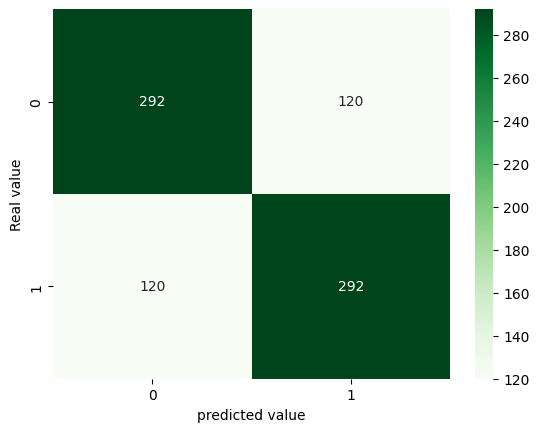

In [222]:
pipeline = Pipeline([('scaler', MinMaxScaler()),
                     ('logreg', LogisticRegression(max_iter=1000))
                     ])

params = {'logreg__penalty': [None, 'l1', 'l2'],
          'logreg__C': np.linspace(0.001, 10000, 24),
          'logreg__solver': ['liblinear', 'newton-cs'],
          'logreg__class_weight': [None],
          'logreg__fit_intercept': [True, False]}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

gs_binary = GridSearchCV(estimator=pipeline, param_grid=params, cv=folds, scoring='f1', verbose=True, n_jobs=-1)

# Обучаем pipeline на тренировочных данных
gs_binary.fit(X_train, y_train)

# Делаем прогнозы на тестовых данных
y_pred = gs_binary.predict(X_test)

# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок
sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

In [223]:
gs_binary.best_params_

{'logreg__C': 434.7835652173913,
 'logreg__class_weight': None,
 'logreg__fit_intercept': False,
 'logreg__penalty': 'l1',
 'logreg__solver': 'liblinear'}

In [255]:
def optimize_and_train(X_train, y_train, X_test, y_test, n_trials=20):
    # Определение пайплайна
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('logreg', LogisticRegression(max_iter=1000))
    ])

    # Определение кросс-валидации
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

    # Функция для оценки модели
    def objective(trial):
        # Определение пространства поиска гиперпараметров
        penalty = trial.suggest_categorical('penalty', [None, 'l2'])
        C = trial.suggest_loguniform('C', 0.001, 10000)
        solver = trial.suggest_categorical('solver', ['lbfgs'])
        class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
        fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
        
        # Установка гиперпараметров
        pipeline.set_params(
            logreg__penalty=penalty,
            logreg__C=C,
            logreg__solver=solver,
            logreg__class_weight=class_weight,
            logreg__fit_intercept=fit_intercept
        )
        
        # Кросс-валидация
        scores = cross_val_score(pipeline, X_train, y_train, cv=folds, scoring='f1')
        return scores.mean()

    # Создание и запуск оптимизатора
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    # Лучшие гиперпараметры
    best_params = study.best_params
    print("Best parameters:", best_params)

    # Обучаем пайплайн с лучшими гиперпараметрами
    pipeline.set_params(
        logreg__penalty=best_params['penalty'],
        logreg__C=best_params['C'],
        logreg__solver=best_params['solver'],
        logreg__class_weight=best_params['class_weight'],
        logreg__fit_intercept=best_params['fit_intercept']
    )
    pipeline.fit(X_train, y_train)

    # Делаем прогнозы на тестовых данных
    y_pred = pipeline.predict(X_test)

    # Определяем вероятности
    y_proba = pipeline.predict_proba(X_test)

    # Выводим метрики качества модели
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Матрица ошибок
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap='Greens')
    plt.ylabel('Real value')
    plt.xlabel('Predicted value')
    plt.show()

    return pipeline, y_pred, y_proba, pipeline.named_steps['logreg']

In [ ]:
pipeline, y_pred, y_proba, model_optuna = optimize_and_train(X_train, y_train, X_test, y_test, n_trials=20)

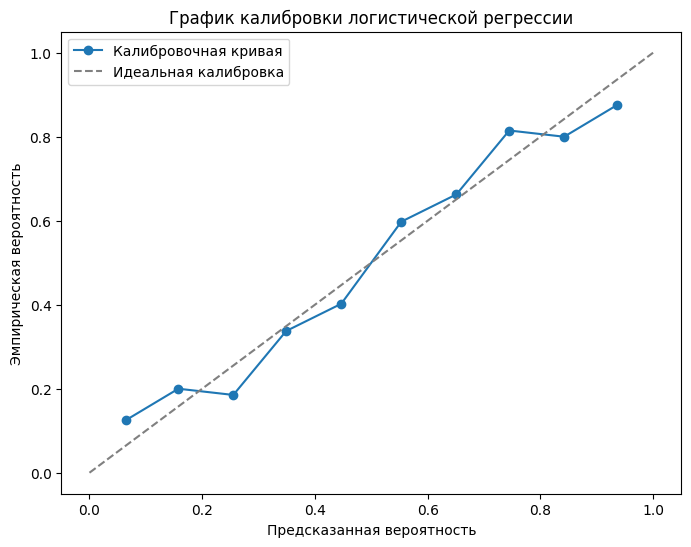

In [224]:
# model = model_optuna
model = gs_binary.best_estimator_

# # Предсказание вероятностей
y_proba = model.predict_proba(X_test)

# Калибровочная кривая
y_proba_positive = y_proba[:, 1]  # Вероятности положительного класса
prob_true, prob_pred = calibration_curve(y_test, y_proba_positive, n_bins=10, strategy="uniform")

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Калибровочная кривая')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Идеальная калибровка')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Эмпирическая вероятность')
plt.title('График калибровки логистической регрессии')
plt.legend()

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       412
           1       0.71      0.71      0.71       412

    accuracy                           0.71       824
   macro avg       0.71      0.71      0.71       824
weighted avg       0.71      0.71      0.71       824



Text(0.5, 23.52222222222222, 'predicted value')

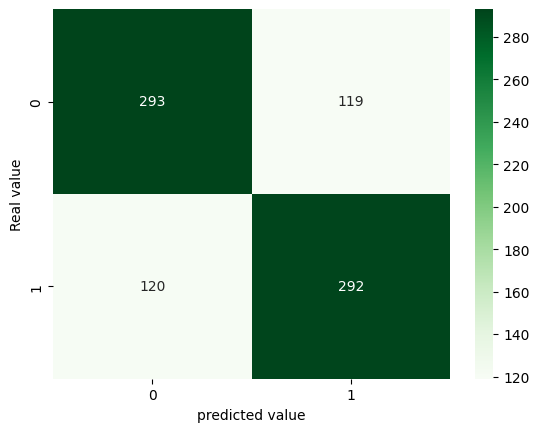

In [225]:
from sklearn.calibration import CalibratedClassifierCV

model = gs_binary.best_estimator_
# model = model_optuna
# Предсказываем вероятности
y_proba_positive = y_proba[:, 1]  # Вероятности положительного класса
calibrated_model = CalibratedClassifierCV(estimator=model, method='isotonic', cv='prefit')
calibrated_model.fit(X_test, y_test)
# Предсказанные вероятности после калибровки
calibrated_proba = calibrated_model.predict_proba(X_test)[:, 1]
# # Калибровочная кривая
prob_true, prob_pred = calibration_curve(y_test, calibrated_proba, n_bins=10, strategy="uniform")

y_pred_calibrated = calibrated_model.predict(X_test)
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred_calibrated))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred_calibrated),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

### Метрика оценки результатов

In [170]:
def calc_odds(row):
    for col in ['RedOdds', 'BlueOdds']:
        if row[col] > 0:
            row[col] = row[col] / 100 + 1
        else:
            row[col] = 100 / np.abs(row[col]) + 1
    return row

import random

def calc_model_gain(row, stake_size = 1000):
    if row['Prediction_Errors'] == 0:
        return int((row['RedOdds'], row['BlueOdds'])[row['ActualWinner']] * stake_size)
    else:
        return - stake_size
    
def calc_odds_gain(row, stake_size = 1000):
    if row['ActualWinner'] == 0 and row['RedOdds'] < row['BlueOdds']:
        return int(row['RedOdds'] * stake_size)
    elif row['ActualWinner'] == 1 and row['RedOdds'] > row['BlueOdds']:
        return int(row['BlueOdds'] * stake_size)
    else:
        return - stake_size


def calc_guess_gain(row, stake_size = 1000):
    odds = (row['RedOdds'], row['BlueOdds'])
    odds_number = (0, 1)
    chosen_odd = random.choice(odds_number)  # Выбираем случайный элемент из кортежа
    if chosen_odd == row['ActualWinner']:
        return int(odds[chosen_odd] * stake_size)
    else:
        return - stake_size

In [226]:
# Создание датафрейма для хранения результатов
results_df = pd.DataFrame({
    'RedFighter': data_final['RedFighter'].iloc[:test_size],
    'BlueFighter': data_final['BlueFighter'].iloc[:test_size],
    'RedOdds': data_final['RedOdds'].iloc[:test_size],
    'BlueOdds': data_final['BlueOdds'].iloc[:test_size],
    'ProbRedWins': y_proba [:, 0],
    'ProbBlueWins': y_proba [:, 1],
    'ActualWinner': data_final['Result'].iloc[:test_size]
})

results_df['Predicted_Winner'] = (results_df['ProbBlueWins'] > results_df['ProbRedWins']).astype(int)
results_df['Prediction_Errors'] = np.abs(results_df['Predicted_Winner'] - results_df['ActualWinner'])
results_df.iloc[:30, :]

,RedFighter,BlueFighter,RedOdds,BlueOdds,ProbRedWins,ProbBlueWins,ActualWinner,Predicted_Winner,Prediction_Errors
1,Shavkat Rakhmonov,Ian Machado Garry,-210.0,295.0,0.695832,0.304168,0,0,0
2,Ciryl Gane,Alexander Volkov,-380.0,300.0,0.304181,0.695819,0,1,1
3,Bryce Mitchell,Kron Gracie,-950.0,625.0,0.719939,0.280061,0,0,0
4,Nate Landwehr,Dooho Choi,-130.0,110.0,0.280053,0.719947,1,1,0
5,Dominick Reyes,Anthony Smith,-380.0,300.0,0.939702,0.060298,0,0,0
6,Vicente Luque,Themba Gorimbo,-650.0,-162.0,0.060301,0.939699,0,1,1
7,Movsar Evloev,Aljamain Sterling,-238.0,195.0,0.558124,0.441876,0,0,0
8,Randy Brown,Bryan Battle,150.0,-180.0,0.441880,0.558120,1,1,0
9,Chris Weidman,Eryk Anders,-112.0,-108.0,0.678555,0.321445,1,0,1
10,Cody Durden,Joshua Van,142.0,-170.0,0.321480,0.678520,1,1,0


In [227]:
results_df = results_df.apply(calc_odds, axis=1)
results_df['Gain_model'] = results_df.apply(calc_model_gain, axis=1)
results_df['Gain_odds'] = results_df.apply(calc_odds_gain, axis=1)
results_df['Gain_guess'] = results_df.apply(calc_guess_gain, axis=1)

print(f'Результат выигрыша при использовании модели: {results_df['Gain_model'].sum()} рублей')
print(f'Результат выигрыша при использовании ставок: {results_df['Gain_odds'].sum()} рублей')
print(f'Результат выигрыша при слепом угадывании: {results_df['Gain_guess'].sum()} рублей')

Результат выигрыша при использовании модели: 343193 рублей
Результат выигрыша при использовании ставок: 589370 рублей
Результат выигрыша при слепом угадывании: 315988 рублей


In [179]:
results_df

,RedFighter,BlueFighter,RedOdds,BlueOdds,ProbRedWins,ProbBlueWins,ActualWinner,Predicted_Winner,Prediction_Errors,Gain_model,Gain_odds,Gain_guess
1,Shavkat Rakhmonov,Ian Machado Garry,1.476190,3.950000,0.695805,0.304195,0,0,0,1476,1476,-1000
2,Ciryl Gane,Alexander Volkov,1.263158,4.000000,0.304188,0.695812,0,1,1,-1000,1263,1263
3,Bryce Mitchell,Kron Gracie,1.105263,7.250000,0.719926,0.280074,0,0,0,1105,1105,-1000
4,Nate Landwehr,Dooho Choi,1.769231,2.100000,0.280074,0.719926,1,1,0,2100,-1000,2100
5,Dominick Reyes,Anthony Smith,1.263158,4.000000,0.939698,0.060302,0,0,0,1263,1263,-1000
...,...,...,...,...,...,...,...,...,...,...,...,...
1117,John Castaneda,Daniel Santos,1.555556,2.550000,0.333479,0.666521,1,1,0,2550,-1000,2550
1118,Ilir Latifi,Aleksei Oleinik,1.512821,2.650000,0.629146,0.370854,0,0,0,1512,1512,1512
1119,Joaquim Silva,Jesse Ronson,1.714286,2.200000,0.370849,0.629151,0,1,1,-1000,1714,1714
1120,Krzysztof Jotko,Brendan Allen,1.800000,2.050000,0.764733,0.235267,1,0,1,-1000,-1000,2050


### Feature Engineering

In [181]:
# Создаем новые признаки
def create_new_features(df): 
    df_copy = df.copy()   
    df_copy['Age_diff'] = df_copy['RedAge'] - df_copy['BlueAge']
    df_copy['Height_diff'] = df_copy['RedHeightCms'] - df_copy['BlueHeightCms']
    df_copy['Reach_diff'] = df_copy['RedReachCms'] - df_copy['BlueReachCms']
    df_copy['Weight_diff'] = df_copy['RedWeightLbs'] - df_copy['BlueWeightLbs']
    # df_copy['Red_wins_loss_diff'] = df_copy['RedWins'] - df_copy['RedLosses']
    # df_copy['Blue_wins_loss_diff'] = df_copy['BlueWins'] - df_copy['BlueLosses']
    # df_copy['Red_Blue_Wins_diff'] = df_copy['RedWins'] - df_copy['BlueWins']
    df_copy['WinsByKO/TKO_diff'] = df_copy['RedWinsByKO/TKO'] - df_copy['BlueWinsByKO/TKO']
    df_copy['WinsBySubmission_diff'] = df_copy['RedWinsBySubmission'] - df_copy['BlueWinsBySubmission']
    df_copy['WinsByDecision_diff'] = df_copy['RedWinsByDecision'] - df_copy['BlueWinsByDecision']
    df_copy['Red_Blue_Loss_diff'] = df_copy['RedLosses'] - df_copy['BlueLosses']
    # Находим разницу между числом побед-поражений для обоих бойцов
    # df_copy['Red_Blue_wins_loss_diff'] = df_copy['Red_wins_loss_diff'] - df_copy['Blue_wins_loss_diff']
    # Находим разницу в статистических показателях для обоих бойцов
    df_copy['AvgSigStrLanded_diff'] = df_copy['RedAvgSigStrLanded'] - df_copy['BlueAvgSigStrLanded']
    df_copy['AvgSigStrPct_diff'] = df_copy['RedAvgSigStrPct'] - df_copy['BlueAvgSigStrPct']
    df_copy['TDAvgLanded_diff'] = df_copy['RedAvgTDLanded'] - df_copy['BlueAvgTDLanded']
    df_copy['AvgTDPct_diff'] = df_copy['RedAvgTDPct'] - df_copy['BlueAvgTDPct']
    df_copy['AvgSubAtt_diff'] = df_copy['RedAvgSubAtt'] - df_copy['BlueAvgSubAtt']
    # Находим разницу для других признаков
    df_copy['LongestWinStreak_diff'] = df_copy['RedLongestWinStreak'] - df_copy['BlueLongestWinStreak']
    df_copy['TotalRoundsFought_diff'] = df_copy['RedTotalRoundsFought'] - df_copy['BlueTotalRoundsFought']
    df_copy['TimeSinceLastFight_diff'] = df_copy['RedTimeSinceLastFight'] - df_copy['BlueTimeSinceLastFight']

    df_copy['Rank_diff'] = df_copy['RMatchWCRank'] - df_copy['BMatchWCRank']
    
    return df_copy

# Находим разницу в текущих сериях побед/поражений для двух бойцов
def red_blue_streak_diff_calc(row):
    if row['RedCurrentWinStreak'] > 0: 
        if row['BlueCurrentWinStreak'] > 0:
            return row['RedCurrentWinStreak'] - row['BlueCurrentWinStreak']
        else:
            return row['RedCurrentWinStreak'] + row['BlueCurrentLoseStreak']
    else:
        if row['BlueCurrentWinStreak'] > 0:
            return -row['RedCurrentLoseStreak'] - row['BlueCurrentWinStreak']
        else:
            return -row['RedCurrentLoseStreak'] + row['BlueCurrentLoseStreak']     

In [182]:
# Убираем исходные признаки и оставляем только созданные
def drop_features(df):
    df_copy = df.copy()
    df_copy = df_copy.drop(columns=[
                          'RedAge',
                          'RedHeightCms',
                          'RedReachCms',
                          'RedWeightLbs',
                          'BlueAge',
                          'BlueHeightCms',
                          'BlueReachCms',
                          'BlueWeightLbs',
                          'RedWins',
                          'RedLosses',
                          'BlueWins',
                          'BlueLosses',
                          'RedCurrentWinStreak',
                          'RedCurrentLoseStreak',
                          'RedTotalRoundsFought',
                          'BlueCurrentWinStreak',
                          'BlueCurrentLoseStreak',
                          #'Red_wins_loss_diff',
                          #'Blue_wins_loss_diff',                                     
                          'WeightClass',
                          'RedAvgSigStrLanded',
                          'RedAvgSigStrPct',
                          'BlueAvgSigStrLanded',
                          'BlueAvgSigStrPct',
                          'RedAvgTDLanded',
                          'RedAvgTDPct', 
                          'BlueAvgTDLanded',
                          'BlueAvgTDPct',
                          'RedAvgSubAtt',                          
                          'BlueAvgSubAtt',
                          'Gender',
                          'NumberOfRounds',
                          'RedWinsBySubmission',
                          'BlueWinsBySubmission',
                          'RedWinsByDecision',
                          'RedWinsByKO/TKO',
                          'BlueWinsByDecision',
                          'BlueWinsByKO/TKO',
                          'BlueTotalRoundsFought',
                          'RedLongestWinStreak',
                          'BlueLongestWinStreak',
                          'RedTimeSinceLastFight',
                          'BlueTimeSinceLastFight',
                          'RMatchWCRank',
                          'BMatchWCRank'
                          ], axis=1)
    return df_copy

In [184]:
data_featured = create_new_features(data_combined.loc[:, :])
data_featured['Red_Blue_curr_streak_diff'] = data_featured.apply(red_blue_streak_diff_calc, axis=1)
data_featured = drop_features(data_featured)
# data_featured = create_new_features(data_final.loc[:, :])
# data_featured['Red_Blue_curr_streak_diff'] = data_featured.apply(red_blue_streak_diff_calc, axis=1)
# data_featured = drop_features(data_featured)

df_test_featured = create_new_features(data_final.loc[:, :])
df_test_featured['Red_Blue_curr_streak_diff'] = df_test_featured.apply(red_blue_streak_diff_calc, axis=1)
df_test_featured = drop_features(df_test_featured)

In [211]:
data_featured_to_export = data_featured#.drop(columns=['RedFighter', 'BlueFighter'], axis=1)
data_featured_to_export.to_csv('data_preprocessed/data_new_combined_featured_rank_6596.csv')
df_test_featured.to_csv('data_preprocessed/data_new_featured_names_rank_3298.csv')

In [209]:
df_test_featured

,RedFighter,BlueFighter,RedStance,BlueStance,RedOdds,BlueOdds,Result,Age_diff,Height_diff,Reach_diff,...,AvgSigStrLanded_diff,AvgSigStrPct_diff,TDAvgLanded_diff,AvgTDPct_diff,AvgSubAtt_diff,LongestWinStreak_diff,TotalRoundsFought_diff,TimeSinceLastFight_diff,Rank_diff,Red_Blue_curr_streak_diff
1,Shavkat Rakhmonov,Ian Machado Garry,0.0,0.0,-210.0,295.0,0,3,-5.08,7.62,...,-1.38,0.060,0.7200,-0.260,1.5000,-2,-9,196,4.0,-2
2,Ciryl Gane,Alexander Volkov,0.0,0.0,-380.0,300.0,0,-2,-7.62,2.54,...,0.36,0.030,0.1300,-0.420,0.3000,3,-11,294,1.0,-3
3,Bryce Mitchell,Kron Gracie,1.0,1.0,-950.0,625.0,0,-6,2.54,0.00,...,-1.44,0.140,2.9800,0.160,1.1000,5,15,-224,3.0,1
4,Nate Landwehr,Dooho Choi,0.0,0.0,-130.0,110.0,1,3,-2.54,5.08,...,1.84,-0.070,0.2500,0.040,0.2000,0,2,112,0.0,0
5,Dominick Reyes,Anthony Smith,1.0,0.0,-380.0,300.0,0,-2,0.00,2.54,...,1.63,0.010,-0.1100,0.020,-0.3000,3,-42,21,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,Frank Mir,Shane Carwin,1.0,0.0,-150.0,140.0,1,-5,2.54,-2.54,...,3.00,0.083,0.4667,0.184,1.2667,1,17,0,0.0,-2
6512,Nate Diaz,Rory Markham,1.0,0.0,-235.0,195.0,0,-4,0.00,12.70,...,0.57,0.134,1.3333,0.476,1.4444,4,18,0,0.0,0
6518,Junior Dos Santos,Gabriel Gonzaga,0.0,0.0,-250.0,230.0,0,-4,5.08,2.54,...,-9.04,-0.010,-1.2000,-0.572,-0.7000,0,-10,0,0.0,3
6521,Clay Guida,Shannon Gugerty,0.0,0.0,-420.0,335.0,0,0,-7.62,-2.54,...,-8.18,0.061,2.1500,-0.281,-0.6500,2,19,0,0.0,-1


In [ ]:
corr_matrix = data_featured_to_export.corr()
plt.figure(figsize=(14, 14))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [199]:
X = data_featured.drop(columns=['Result','RedFighter', 'BlueFighter'], axis=1)
y = data_featured['Result']

X_test = df_test_featured.drop(columns=['Result','RedFighter', 'BlueFighter'], axis=1)
y_test = df_test_featured['Result']

# X = X.iloc[:2000, :]
# y = y.iloc[:2000]

# train_size = 
# test_size = int(len(X) * 0.125)


X_train_featured = X.iloc[train_size:, :]
y_train = y.iloc[train_size:]

X_test_featured = X_test.iloc[:test_size, :]
y_test = y_test.iloc[:test_size]
# X_train_featured = X.iloc[test_size:, :]
# y_train = y.iloc[test_size:]

# X_test_featured = X.iloc[:test_size, :]
# y_test = y.iloc[:test_size]

In [216]:
X_train_featured

,RedStance,BlueStance,RedOdds,BlueOdds,Age_diff,Height_diff,Reach_diff,Weight_diff,WinsByKO/TKO_diff,WinsBySubmission_diff,...,AvgSigStrLanded_diff,AvgSigStrPct_diff,TDAvgLanded_diff,AvgTDPct_diff,AvgSubAtt_diff,LongestWinStreak_diff,TotalRoundsFought_diff,TimeSinceLastFight_diff,Rank_diff,Red_Blue_curr_streak_diff
616,1.0,0.0,-325.0,260.0,3,-10.16,-2.54,0,3,-1,...,1.81,0.100,0.54,0.280,-1.10,1,3,14,0.0,1
616,0.0,1.0,260.0,-325.0,-3,10.16,2.54,0,-3,1,...,-1.81,-0.100,-0.54,-0.280,1.10,-1,-3,-14,0.0,-1
617,0.0,0.0,-125.0,105.0,-5,-5.08,-7.62,0,0,0,...,-0.07,0.020,-0.30,0.040,-0.20,3,0,399,2.0,3
617,0.0,0.0,105.0,-125.0,5,5.08,7.62,0,0,0,...,0.07,-0.020,0.30,-0.040,0.20,-3,0,-399,2.0,-3
620,1.0,0.0,-550.0,410.0,2,7.62,10.16,0,1,-1,...,-2.01,0.060,-0.73,-0.520,-0.10,3,-1,84,5.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6518,0.0,0.0,230.0,-250.0,4,-5.08,-2.54,4,1,2,...,9.04,0.010,1.20,0.572,0.70,0,10,0,0.0,-3
6521,0.0,0.0,-420.0,335.0,0,-7.62,-2.54,0,1,-1,...,-8.18,0.061,2.15,-0.281,-0.65,2,19,0,0.0,-1
6521,0.0,0.0,335.0,-420.0,0,7.62,2.54,0,-1,1,...,8.18,-0.061,-2.15,0.281,0.65,-2,-19,0,0.0,1
6525,0.0,0.0,-260.0,220.0,0,2.54,2.12,-20,0,0,...,4.00,-0.090,-1.00,-1.000,-1.00,0,0,0,0.0,0


In [193]:
gs_binary.best_params_

{'logreg__C': 434.7835652173913,
 'logreg__class_weight': None,
 'logreg__fit_intercept': False,
 'logreg__penalty': 'l1',
 'logreg__solver': 'liblinear'}

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.76      0.74       465
           1       0.67      0.63      0.65       359

    accuracy                           0.70       824
   macro avg       0.70      0.70      0.70       824
weighted avg       0.70      0.70      0.70       824



Text(0.5, 23.52222222222222, 'predicted value')

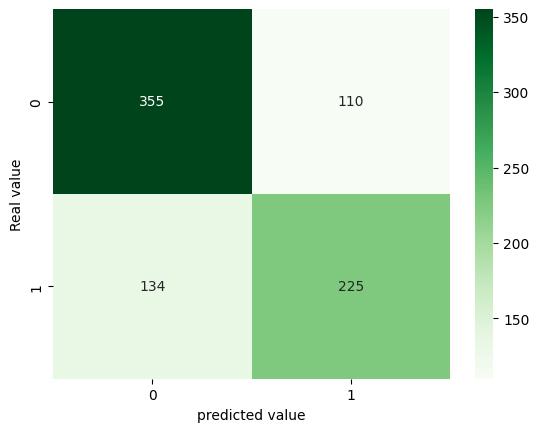

In [201]:
# Обучаем pipeline на тренировочных данных
gs_binary.fit(X_train_featured, y_train)


# log_reg_featured = LogisticRegression(penalty='l1',
#                                       C = 435, 
#                                       solver = 'liblinear', 
#                                       class_weight = None, 
#                                       fit_intercept=False)

# log_reg_featured.fit(X_train_featured, y_train)

# Делаем прогнозы на тестовых данных
y_pred = gs_binary.predict(X_test_featured)
# y_pred = log_reg_featured.predict(X_test_featured)

# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок
sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

In [ ]:
pipeline, y_pred, y_proba, model = optimize_and_train(X_train_featured, y_train, X_test_featured, y_test, n_trials=25)

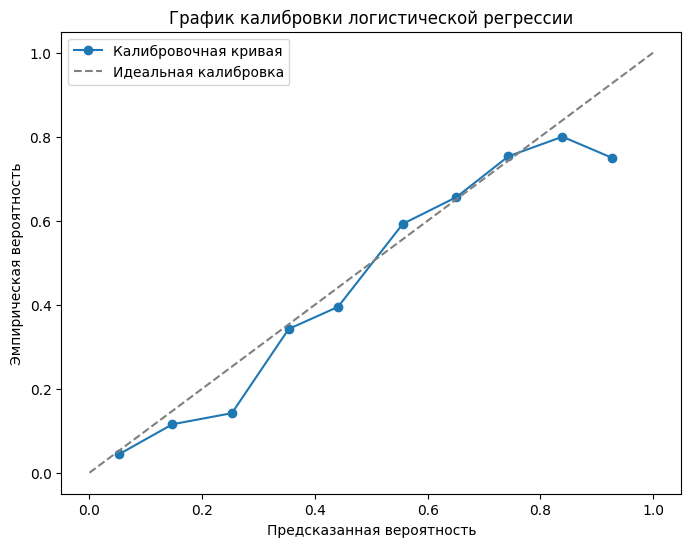

In [202]:
# Предсказание вероятностей
# model = model

y_proba = gs_binary.predict_proba(X_test_featured)
# y_proba = model.predict_proba(X_test_featured)

# Калибровочная кривая
y_proba_positive = y_proba[:, 1]  # Вероятности положительного класса
prob_true, prob_pred = calibration_curve(y_test, y_proba_positive, n_bins=10, strategy="uniform")

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Калибровочная кривая')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Идеальная калибровка')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Эмпирическая вероятность')
plt.title('График калибровки логистической регрессии')
plt.legend()

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       465
           1       0.68      0.62      0.65       359

    accuracy                           0.71       824
   macro avg       0.70      0.70      0.70       824
weighted avg       0.70      0.71      0.70       824



Text(0.5, 23.52222222222222, 'predicted value')

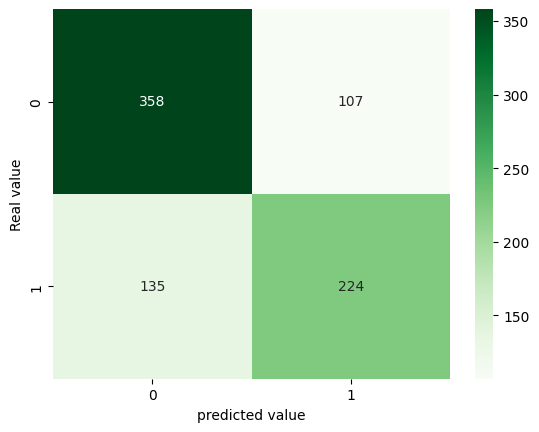

In [203]:
model = gs_binary.best_estimator_
# model = model
# Предсказываем вероятности
y_proba_positive = y_proba[:, 1]  # Вероятности положительного класса
calibrated_model = CalibratedClassifierCV(estimator=model, method='isotonic', cv='prefit')
calibrated_model.fit(X_test_featured, y_test)
# Предсказанные вероятности после калибровки
calibrated_proba = calibrated_model.predict_proba(X_test_featured)[:, 1]
# # Калибровочная кривая
prob_true, prob_pred = calibration_curve(y_test, calibrated_proba, n_bins=10, strategy="uniform")

y_pred_calibrated = calibrated_model.predict(X_test_featured)
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred_calibrated))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred_calibrated),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

In [204]:
def calc_odds(row):
    for col in ['RedOdds', 'BlueOdds']:
        if row[col] > 0:
            row[col] = row[col] / 100 + 1
        else:
            row[col] = 100 / np.abs(row[col]) + 1
    return row

import random

def calc_model_gain(row, stake_size = 1000):
    if row['Prediction_Errors'] == 0:
        return int((row['RedOdds'], row['BlueOdds'])[row['ActualWinner']] * stake_size)
    else:
        return - stake_size
    
def calc_odds_gain(row, stake_size = 1000):
    if row['ActualWinner'] == 0 and row['RedOdds'] < row['BlueOdds']:
        return int(row['RedOdds'] * stake_size)
    elif row['ActualWinner'] == 1 and row['RedOdds'] > row['BlueOdds']:
        return int(row['BlueOdds'] * stake_size)
    else:
        return - stake_size


def calc_guess_gain(row, stake_size = 1000):
    odds = (row['RedOdds'], row['BlueOdds'])
    odds_number = (0, 1)
    chosen_odd = random.choice(odds_number)  # Выбираем случайный элемент из кортежа
    if chosen_odd == row['ActualWinner']:
        return int(odds[chosen_odd] * stake_size)
    else:
        return - stake_size

In [47]:
fighters = pd.read_csv('data_preprocessed/data_new_featured__with_odds_names_3298.csv', index_col='Unnamed: 0')

In [205]:
# Создание датафрейма для хранения результатов
results_df = pd.DataFrame({
    'RedFighter': data_final['RedFighter'].iloc[:test_size],
    'BlueFighter': data_final['BlueFighter'].iloc[:test_size],
    'RedOdds': data_final['RedOdds'].iloc[:test_size],
    'BlueOdds': data_final['BlueOdds'].iloc[:test_size],
    'ProbabilityRedWins': y_proba [:, 0],
    'ProbabilityBlueWins': y_proba [:, 1],
    'ActualWinner': data_final['Result'].iloc[:test_size]
})

results_df['Predicted_Winner'] = (results_df['ProbabilityBlueWins'] > results_df['ProbabilityRedWins']).astype(int)
results_df['Prediction_Errors'] = np.abs(results_df['Predicted_Winner'] - results_df['ActualWinner'])
results_df.iloc[:, :]

,RedFighter,BlueFighter,RedOdds,BlueOdds,ProbabilityRedWins,ProbabilityBlueWins,ActualWinner,Predicted_Winner,Prediction_Errors
1,Shavkat Rakhmonov,Ian Machado Garry,-210.0,295.0,0.695255,0.304745,0,0,0
2,Ciryl Gane,Alexander Volkov,-380.0,300.0,0.745796,0.254204,0,0,0
3,Bryce Mitchell,Kron Gracie,-950.0,625.0,0.947725,0.052275,0,0,0
4,Nate Landwehr,Dooho Choi,-130.0,110.0,0.556382,0.443618,1,0,1
5,Dominick Reyes,Anthony Smith,-380.0,300.0,0.697602,0.302398,0,0,0
...,...,...,...,...,...,...,...,...,...
1117,John Castaneda,Daniel Santos,-180.0,155.0,0.625933,0.374067,1,0,1
1118,Ilir Latifi,Aleksei Oleinik,-195.0,165.0,0.616381,0.383619,0,0,0
1119,Joaquim Silva,Jesse Ronson,-140.0,120.0,0.573419,0.426581,0,0,0
1120,Krzysztof Jotko,Brendan Allen,-125.0,105.0,0.544194,0.455806,1,0,1


In [206]:
results_df = results_df.apply(calc_odds, axis=1)
results_df['Gain_model'] = results_df.apply(calc_model_gain, axis=1)
results_df['Gain_odds'] = results_df.apply(calc_odds_gain, axis=1)
results_df['Gain_guess'] = results_df.apply(calc_guess_gain, axis=1)

print(f'Результат выигрыша при использовании модели: {results_df['Gain_model'].sum()} рублей')
print(f'Результат выигрыша при использовании ставок: {results_df['Gain_odds'].sum()} рублей')
print(f'Результат выигрыша при слепом угадывании: {results_df['Gain_guess'].sum()} рублей')

Результат выигрыша при использовании модели: 607560 рублей
Результат выигрыша при использовании ставок: 589370 рублей
Результат выигрыша при слепом угадывании: 264701 рублей
